# import Library 
- ### Hello ,We will develop a Convolutional Neural Network (CNN) model to analyze and classify images from our lung dataset.

![Resim Açıklaması](https://media.springernature.com/lw1200/springer-static/image/art%3A10.1038%2Fs41572-021-00259-0/MediaObjects/41572_2021_259_Fig6_HTML.png){: width="600" height="400"}

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

import cv2 # open cv
import os 

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

In [2]:
import os

train_path = r'/kaggle/input/chest-xray-pneumonia/chest_xray/'

if os.path.exists(train_path):
    print("Index available. The content is being checked...")
    for label in os.listdir(train_path):
        label_path = os.path.join(train_path, label)
        if os.path.isdir(label_path):  
            print(f"'{label}' klasörü: {os.listdir(label_path)}")
else:
    print("Index not available.")

Index available. The content is being checked...
'chest_xray' klasörü: ['val', '.DS_Store', 'test', 'train']
'__MACOSX' klasörü: ['chest_xray', '._chest_xray']
'val' klasörü: ['PNEUMONIA', 'NORMAL']
'test' klasörü: ['PNEUMONIA', 'NORMAL']
'train' klasörü: ['PNEUMONIA', 'NORMAL']


# Load Data


In [3]:
import os
import cv2
import numpy as np
from tqdm import tqdm

labels = ['PNEUMONIA', 'NORMAL']
img_size = 150  # image size

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)  # Folder path 
        class_num = labels.index(label)  # 'PNEUMONIA' -> 0, 'NORMAL' -> 1
        
        for img in tqdm(os.listdir(path)):
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            if img_arr is None:
                print(f'Error reading image: {img}')
                continue
            resized_arr = cv2.resize(img_arr, (img_size, img_size))
            data.append([resized_arr, class_num])
            
    return np.array(data, dtype=object)  # Fixed



def get_train_data(train_path):
    print("Uploading training data...")
    return get_data(train_path)

def get_test_data(test_path):
    print("Uploading test data...")
    return get_data(test_path)

def get_val_data(val_path):
    print("Uploading validation data...")
    return get_data(val_path)

# Usage 
train_path = r'/kaggle/input/chest-xray-pneumonia/chest_xray/train'
test_path = r'/kaggle/input/chest-xray-pneumonia/chest_xray/test'
val_path = r'/kaggle/input/chest-xray-pneumonia/chest_xray/val'

train_data = get_train_data(train_path)
test_data = get_test_data(test_path)
val_data = get_val_data(val_path)

print("Train : ", train_data.shape, "\n", 'Validation : ', val_data.shape, "\n", 'Test : ', test_data.shape)

Uploading training data...


100%|██████████| 1341/1341 [00:28<00:00, 47.53it/s]


Uploading test data...


100%|██████████| 234/234 [00:03<00:00, 64.98it/s]


Uploading validation data...


100%|██████████| 8/8 [00:00<00:00, 66.89it/s]

Train :  (5216, 2) 
 Validation :  (16, 2) 
 Test :  (624, 2)


# Data visualization and preprocessing

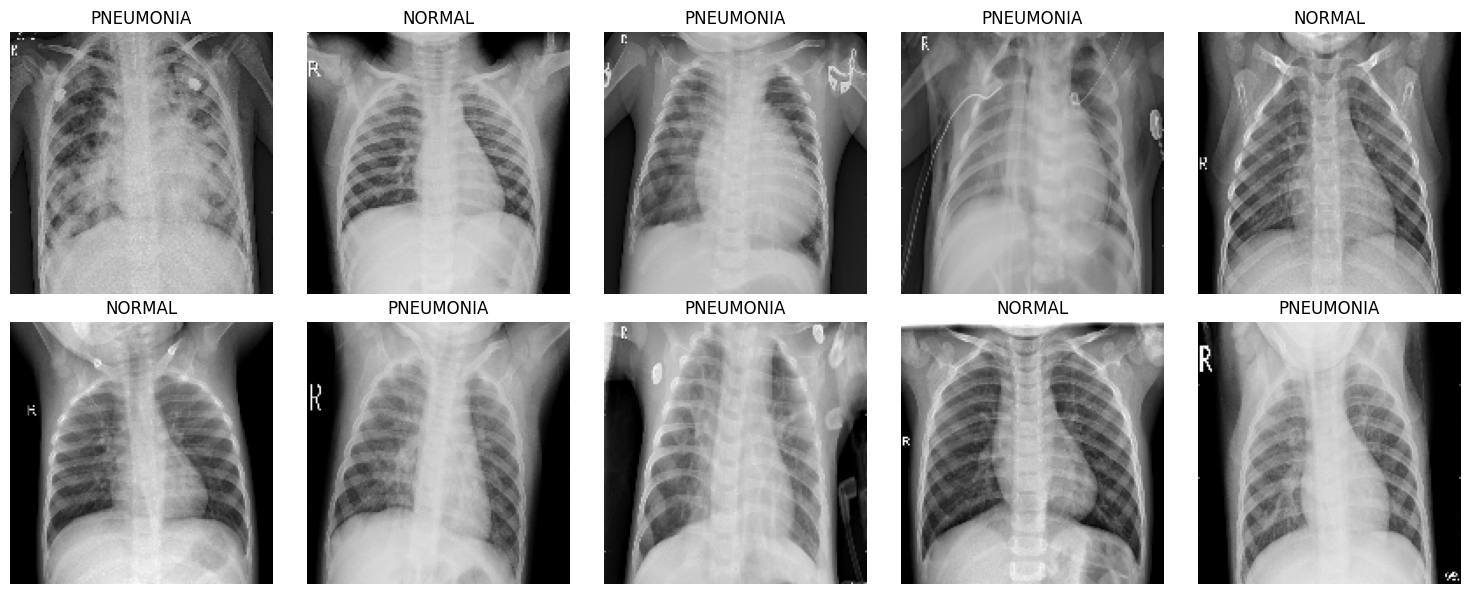

In [4]:
import random 
def display_random_samples(data, num_samples=10):
    plt.figure(figsize=(15, 6))
    
    random_samples = random.sample(list(data), num_samples) 
    
    for i, (img, label) in enumerate(random_samples):
        plt.subplot(2, 5, i + 1)   # 2 rows, 5 columns
        plt.imshow(img, cmap='gray')
        plt.title(labels[label])  
        plt.axis('off')  
    plt.tight_layout()
    plt.show()
    
display_random_samples(train_data, num_samples=10)

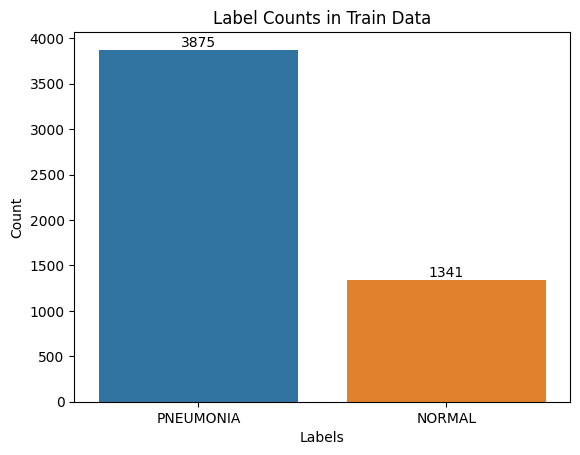

In [5]:
l=[]
for i in train_data :
    if(i[1]==0):
        l.append('PNEUMONIA')
    else:
        l.append('NORMAL')
#sns.countplot(x=l)

ax = sns.countplot(x=l)

for p in ax.patches:
    ax.annotate(str(int(p.get_height())), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')

plt.title('Label Counts in Train Data')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

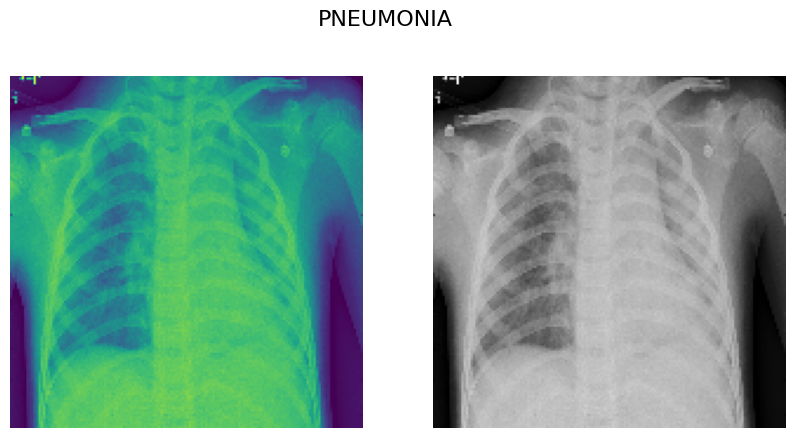

In [6]:
# let's mix our data so that we don't have problems in the future
train_data = np.array(train_data)
np.random.shuffle(train_data)

x_train = np.array([i[0] for i in train_data])
y_train = np.array([i[1] for i in train_data])

x_test = np.array([i[0] for i in test_data])
y_test = np.array([i[1] for i in test_data])

x_val = np.array([i[0] for i in val_data])
y_val = np.array([i[1] for i in val_data])



    
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(x_train[0])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(x_train[0], cv2.COLOR_GRAY2RGB))
plt.axis('off')

plt.suptitle(labels[y_train[0]], fontsize=16)
plt.show()

In [7]:
x_train[1]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

- ## We will normalize the values from 0 to 255 and bring them to the range of 0 and 1 so that the model will learn better and faster.

In [8]:
# Normalization [0 , 255]   / 255 = [0,1]
x_train=np.array(x_train)/255
x_test=np.array(x_test)/255
x_val=np.array(x_val)/255

# (5216 ,150 ,150) --> (5216 ,150 ,150 ,1) for Deeplearning
## Additional Dimension: The last dimension, 1, indicates that images are single channel (grayscale). 
#Color images typically have three channels (RGB), while grayscale images have a single channel.

x_train=x_train.reshape(-1,img_size,img_size,1)  # channel 1 ->(grey)
x_test=x_test.reshape(-1,img_size,img_size,1)
x_val=x_val.reshape(-1,img_size,img_size,1)

y_train=np.array(y_train)
y_test=np.array(y_test)
y_val=np.array(y_val)

# Data agumentation

- ### to increase generalization we resort to data augmentation 

In [9]:
"""from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=False,  # Set input mean to 0 over the dataset
    samplewise_center=False,    # Set each sample mean to 0
    featurewise_std_normalization=False,  # Divide inputs by std of the dataset
    samplewise_std_normalization=False,   # Divide each sample by its std
    zca_whitening=False,        # Apply ZCA whitening
    rotation_range=30,          # Randomly rotate images in the range (degrees)
    zoom_range=0.2,             # Randomly zoom into images
    width_shift_range=0.1,      # Randomly shift images horizontally
    height_shift_range=0.1,     # Randomly shift images vertically
    horizontal_flip=True,       # Randomly flip images horizontally
    vertical_flip=True          # Randomly flip images vertically
)
datagen.fit(x_train)

"""

'from tensorflow.keras.preprocessing.image import ImageDataGenerator\n\ndatagen = ImageDataGenerator(\n    featurewise_center=False,  # Set input mean to 0 over the dataset\n    samplewise_center=False,    # Set each sample mean to 0\n    featurewise_std_normalization=False,  # Divide inputs by std of the dataset\n    samplewise_std_normalization=False,   # Divide each sample by its std\n    zca_whitening=False,        # Apply ZCA whitening\n    rotation_range=30,          # Randomly rotate images in the range (degrees)\n    zoom_range=0.2,             # Randomly zoom into images\n    width_shift_range=0.1,      # Randomly shift images horizontally\n    height_shift_range=0.1,     # Randomly shift images vertically\n    horizontal_flip=True,       # Randomly flip images horizontally\n    vertical_flip=True          # Randomly flip images vertically\n)\ndatagen.fit(x_train)\n\n'

# Create deep learning model and train 


Epoch 1/50


I0000 00:00:1734320532.999921      71 service.cc:145] XLA service 0x7a10a800cc80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734320533.000010      71 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  4/163 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.7982 - loss: 1.1036

I0000 00:00:1734320540.395697      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 72ms/step - accuracy: 0.7433 - loss: 0.6436 - val_accuracy: 0.6346 - val_loss: 0.6473 - learning_rate: 0.0010
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.7508 - loss: 0.4762 - val_accuracy: 0.6554 - val_loss: 0.6766 - learning_rate: 0.0010
Epoch 3/50
161/163 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7939 - loss: 0.4065
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.7942 - loss: 0.4061 - val_accuracy: 0.6859 - val_loss: 0.6826 - learning_rate: 0.0010
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.8611 - loss: 0.3269 - val_accuracy: 0.7516 - val_loss: 0.6206 - learning_rate: 5.0000e-04
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.8897 - loss: 0.2706 - val_accuracy: 0.7821 - val_loss: 0.4994 - learning_rate: 5.0000e-04
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8843 - loss: 

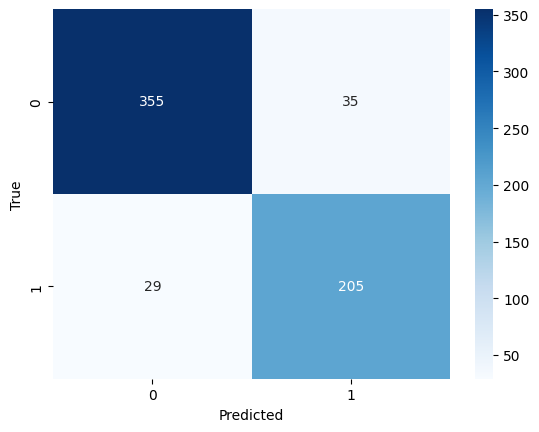

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       390
           1       0.85      0.88      0.86       234

    accuracy                           0.90       624
   macro avg       0.89      0.89      0.89       624
weighted avg       0.90      0.90      0.90       624



In [10]:
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

epoch_number = 50
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=epoch_number,
    validation_data=datagen.flow(x_test, y_test),
    callbacks=[learning_rate_reduction, early_stopping]
)

print("Loss of model: ", model.evaluate(x_test, y_test)[0])
print("Accuracy of model: ", model.evaluate(x_test, y_test)[1] * 100)
    
y_pred = (model.predict(x_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_test, y_pred))

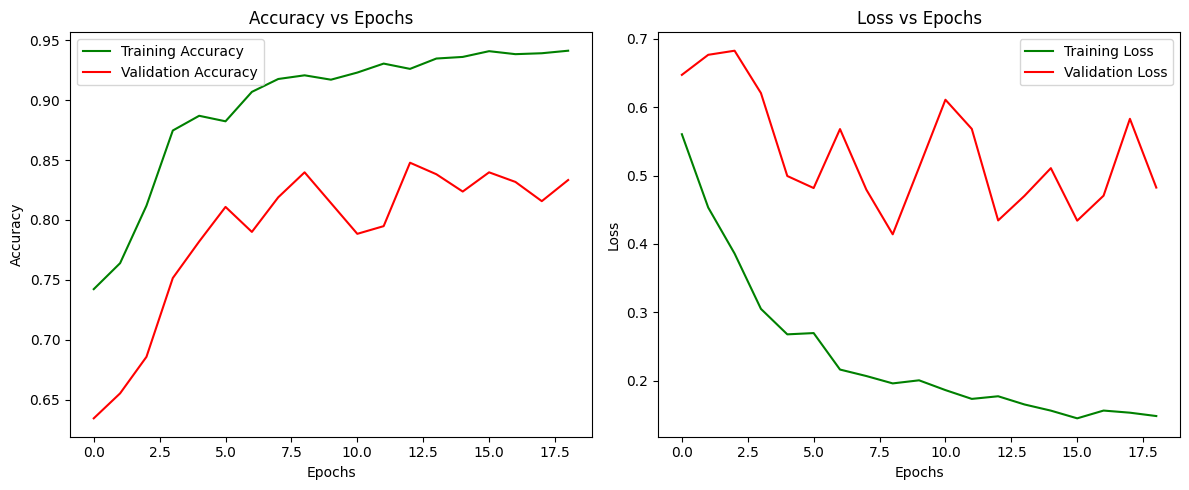

In [11]:
epochs = range(len(history.history['accuracy']))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], 'g-', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'r-', label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], 'g-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
import glob
from keras.preprocessing import image

def predict_image(model, img_path):
    img = image.load_img(img_path, target_size=(150, 150), color_mode='grayscale')
    img = np.expand_dims(image.img_to_array(img) / 255.0, axis=0)
    prediction = model.predict(img)
    return 'Pneumonia' if prediction[0] > 0.5 else 'Healthy'

val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
all_images_paths = glob.glob(os.path.join(val_dir, 'NORMAL', '*.jpeg')) + \
                   glob.glob(os.path.join(val_dir, 'PNEUMONIA', '*.jpeg'))

for img_path in all_images_paths:
    prediction = predict_image(model, img_path)
    print(f'{os.path.basename(img_path)}: {prediction}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
NORMAL2-IM-1431-0001.jpeg: Pneumonia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
NORMAL2-IM-1440-0001.jpeg: Pneumonia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
NORMAL2-IM-1442-0001.jpeg: Pneumonia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
NORMAL2-IM-1427-0001.jpeg: Pneumonia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
NORMAL2-IM-1430-0001.jpeg: Pneumonia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
NORMAL2-IM-1436-0001.jpeg: Pneumonia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
NORMAL2-IM-1438-0001.jpeg: Pneumonia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
NORMAL2-IM-1437-0001.jpeg: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
person1947_bacteria_4876.jpeg: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
person1946_bacteria_4875.jpeg: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
person1952_bacteria_4883.jpeg: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
person1954_bacteria_4886.jpeg: Pneumonia
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
person1951_bacteria_4882.jpeg: Healthy
1/1 ━━━━━━━━━━